Import core numerical and utility functionality

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from scipy.integrate import odeint
from scipy.optimize import fsolve

Setup

In [5]:
np.random.seed(42)

NAME = 'assignment2'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


## Part 1: Perfect Adaptation

### a) Rate-equation of $R$

Steady-state solution with rate constants $k_1=k_2=2$, $k_3=k_4=1$ plugged in:

$$
\begin{align*}
    \frac{dX}{dt} &=  k_3 S - k_4 X = S - X = 0 \implies X = S \\
    \frac{dR}{dt} &= k_1 S - k_2 X R = 2 S - 2 X R = 2 S - 2 S R = 2 S (1 - R) \\
\end{align*}
$$

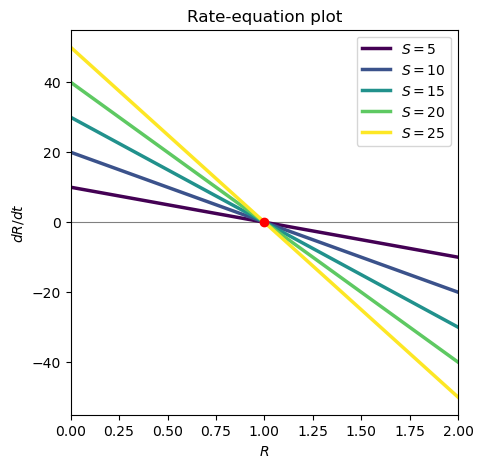

In [6]:
Ss = [5, 10, 15, 20, 25]
Rs = np.linspace(0, 2, 1000)

fig, ax = plt.subplots(1,1, figsize=(5,5))
cmap = plt.get_cmap(name="viridis", lut=len(Ss))

ax.hlines(0, 0, 2, lw=0.8, color="gray")
for (i, S) in enumerate(Ss):
    dRdt = 2 * S * (1-Rs)
    ax.plot(Rs, dRdt, color=cmap(i), label=r"$S=$" + f"{S}", lw=2.5)

ax.scatter(1,0,color="red",zorder=10)
ax.set_xlabel(r"$R$")
ax.set_ylabel(r"$dR/dt$")
ax.set_xlim((0,2))
ax.set_title("Rate-equation plot")
ax.legend()

plt.show()

### b) Signal-response curve

It can be seen from the rate-equation plot of $R$, but also it can be derived analytically that:

$$ S \neq 0 \implies \left( \frac{dR}{dt} = 0 \iff R = 1 \right) $$

The equilibrium point $R^{*}$ is always equal to $1$ and is independent of $S$. The signal-response curve will be a horizontal line.

As can also be seen in the rate-equation plot, $\frac{dR}{dt} \gt 0$ leftwards from the equilibrium and $\frac{dR}{dt} \lt 0$ rightwards from the equilibrium. Thus, the equilbrium point $R^{*} = 1$ is stable.

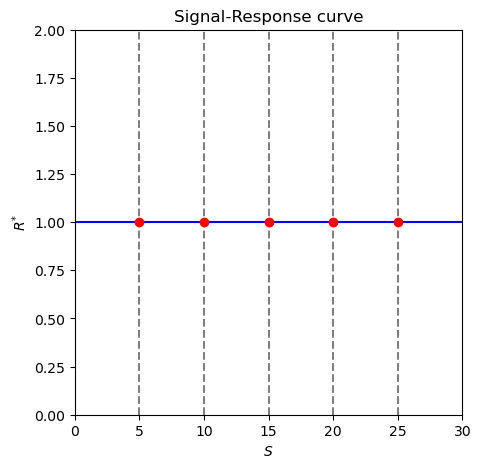

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hlines(1, 0, 30, color="blue")
ax.scatter(Ss, np.ones(len(Ss)), color="red",zorder=10)

for (i, S) in enumerate(Ss):
    ax.vlines(S, 0, 2, linestyles="dashed", color="gray")

ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$R^{*}$")

ax.set_xlim((0,30))
ax.set_ylim(0,2)
ax.set_title("Signal-Response curve")

plt.show()

### c) Time-dependent plots

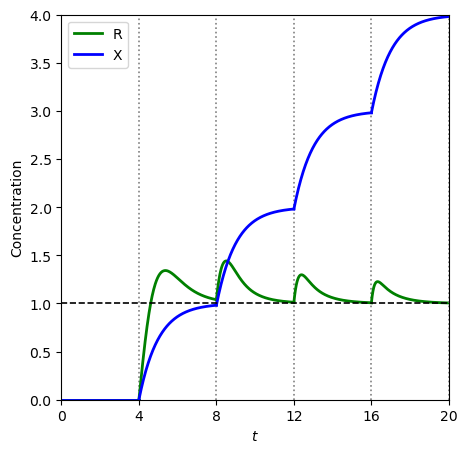

In [8]:
def perfect_adaptation(y0, t, S):
    R, X = y0
    dRdt = 2*S - 2*X*R
    dXdt = S - X
    dydt = [dRdt, dXdt]

    return dydt

Ss = np.array([0,1,2,3,4])
fig, ax = plt.subplots(1,1,figsize=(5,5))

R0 = 0
X0 = 0
y0 = [R0, X0]

for (i, S) in enumerate(Ss):
    t = np.linspace(i*4, (i+1)*4, 200)
    sol = odeint(perfect_adaptation, y0, t, args=(S,))

    R, X = sol[:, 0], sol[:, 1]
    ax.plot(t, R, color="green", lw=2.0)
    ax.plot(t, X, color="blue", lw=2.0)

    ax.vlines((i+1)*4, 0, 4, linestyles="dotted", lw=1.2, color="gray")

    y0 = [R[-1], X[-1]]

ax.hlines(1, 0, 20, linestyles="dashed", lw=1.2, color="black")

ax.set_xlim(0,20)
ax.set_ylim(0,4)
ax.set_xticks([0,4,8,12,16,20])
ax.set_xlabel(r"$t$")
ax.set_ylabel("Concentration")
ax.legend(["R", "X"])

plt.show()


The concentration of $R$ remains stable at the zero-level when $S=0$. This result could not be seen in the signal-response curve, as it was assumed that $S \neq 0$. Nonetheless, $S = 0$ is another solution for $\frac{dR}{dt} = 0$, which results in concentration of $R$ remaining at the same level for this time period.

For all remaining periods, where $S \in \{1,2,3,4\}$, the concentration of $R$ rises at first, but then starts to down-regulate and approaching $R^{*} = 1$. This corresponds with signal-response curve. Stable point $R^{*} = 1$ is independent of $S$.

The concentration of $X$ also corresponds with the previous derivation from $a)$, where, to achieve a steady-state solution, it was shown that $S = X$. At the beginning of each period, $X$ up-regulates. The increase is rapid at first, but then slows down and the concentration level approaches $X^{*}$ equal to the corresponding $S$.

## Part 2: Feedback loops

### a) Rate-equations

In [9]:
def G(u,v,J,K):
    """The Goldbeter-Koshland function."""
    inside_root = (v-u+v*J+u*K)**2 - 4*(v-u)*u*K
    assert len(inside_root[inside_root<0]) == 0, 'No complex solutions desired'
    return (2*u*K) / (v - u + v*J + u*K + np.sqrt(inside_root))

In [10]:
def homeostasis(R, S, k0, k2, k3, k4, j3, j4):
    ER = G(k3, k4*R, j3, j4)
    dRdt = k0 * ER - k2 * S * R
    return dRdt

def mutual_inhibition(R, S, k0, k1, k2, k2_prime, k3, k4, j3, j4):
    ER = G(k3, k4*R, j3, j4)
    dRdt = k0 + k1*S - k2*R - k2_prime*ER*R
    return dRdt

def mutual_activation(R, S, k0, k1, k2, k3, k4, j3, j4):
    ER = G(k3*R, k4, j3, j4)
    dRdt = k0*ER + k1*S - k2*R
    return dRdt

In [11]:
def plot_rate_equation(ax, Rs, Ss, model, *args):
    # Code for plotting the rate equation on a given axis, provided response levels Rs, stimulus levels Ss and the corresponding model
    cmap = plt.get_cmap(name="viridis", lut=len(Ss))
    ax.hlines(0, 0, np.max(Rs), lw=0.8, color="gray")

    for (i, S) in enumerate(Ss):
        dRdt = model(Rs, S, *args)
        ax.plot(Rs, dRdt, color=cmap(i), label=r"$S=$" + f"{S}", lw=2.5)

    max_y = max(dRdt)*1.1
    ax.set_ylim(-max_y, max_y)
    ax.set_xlabel(r"$R$")
    ax.set_ylabel(r"$dR/dt$")
    ax.set_xlim((0,np.max(Rs)))
    ax.set_xticks(np.linspace(0, np.max(Rs), 5))
    ax.legend()

def param_set(**kwargs):
    return kwargs

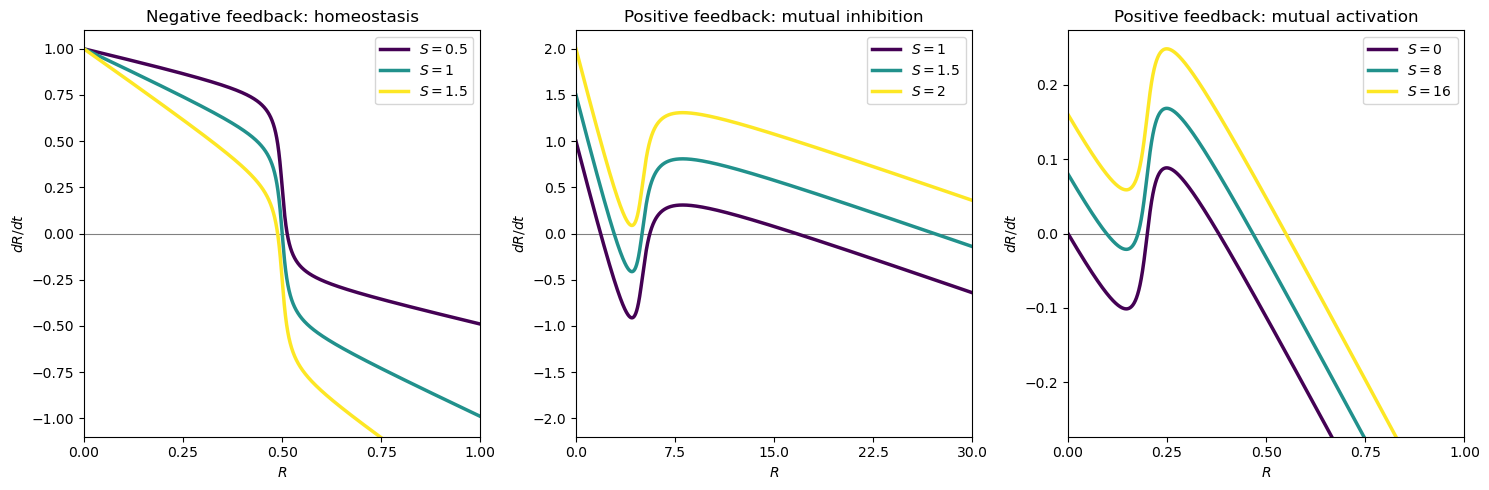

In [12]:
fig, ax = plt.subplots(1,3,figsize=(15,5), layout='tight')

# --- Negative feedback: homeostasis ---
params_homeostasis = param_set(k0=1, k2=1, k3=0.5, k4=1, j3=0.01, j4=0.01)
Ss = [0.5, 1, 1.5]
Rs = np.linspace(0, 1, 10000)
plot_rate_equation(ax[0], Rs, Ss, homeostasis, *params_homeostasis.values())
ax[0].set_title("Negative feedback: homeostasis")

# --- Positive feedback: mutual inhibition ---
params_mutual_inhibition = param_set(k0=0, k1 = 1, k2 = 0.05, k2_prime = 0.5, k3 = 1, k4 = 0.2, j3 = 0.05, j4 = 0.05)
Ss = [1,1.5,2]
Rs = np.linspace(0, 30, 10000)
plot_rate_equation(ax[1], Rs, Ss, mutual_inhibition, *params_mutual_inhibition.values())
ax[1].set_title("Positive feedback: mutual inhibition")

# --- Positive feedback: mutual activation ---
params_mutual_activation = param_set(k0 = 0.4, k1 = 0.01, k2 = 1, k3 = 1, k4 = 0.2, j3 = 0.05, j4 = 0.05)
Ss = [0,8,16]
Rs = np.linspace(0, 1, 10000)
plot_rate_equation(ax[2], Rs, Ss, mutual_activation, *params_mutual_activation.values())
ax[2].set_title("Positive feedback: mutual activation")

plt.show()

### b) Signal-response curves (Bifurcation plots)

The approximate roots of rates $\frac{dR}{dt}$ could be read from the plot, but to create a bifurcation diagram, more evaluations for different $S$ are needed. The analytical solution for the root of $\frac{dR}{dt}$ is very much non-trivial due to the complexity of the Goldbeter-Koshland function. We will use numerical methods to find all roots.

To find all roots, we will utilize the `scipy.optimize.fsolve` method, which finds the root(s) of the function, given the initial estimate(s). To create a bifurcation plot we need to find all function roots $R^{*}$ for a given signal strength $S$. Finding all function roots is a difficult numerical task, but we can do that for these three specific scenarios by only looking through the subset of the domain, based on the plots from a).

Given the interval $[ x_{\text{start}}, x_{\text{stop}} ]$ and the step size $\Delta x$ the `fsolve` was evaluated for all initial estimates $x \in \{ x_{\text{start}}, x_{\text{start}} + \Delta x, \dots, x_{\text{stop}} \}$. If `fsolve` returned a root that wasn't found before (for the comparison, `np.isclose` was used), the root was added to the list. This step was repeated for all signal strengths $s \in S$ supplied as a function parameter.

The algorithm for finding roots of function $f(R, S, \dots)$, where $\dots$ represents function-dependent additional parameters such as $k_0, k_1, k_2, \dots$ presents as follows:

Given:
   * $f$ function for which we want to find the roots
   * $s$ signal strength
   * $x_{\text{start}}$ starting point of scanning domain subset
   * $x_{\text{stop}}$ end point of for scanning domain subset 
   * $\Delta x$ step size for scanning domain subset
1. Initialize empty array $R$ where the roots will be stored
2. For all $x \in \{ x_{\text{start}}, x_{\text{start}} + \Delta x, \dots, x_{\text{stop}} \}$:
   1. Find $r$ root of $f$ using `fsolve` and starting estimate $x$
   2. If $r \notin R$, add $r$ to $R$

In [13]:
def find_roots(func, xmin, xmax, dx):
    roots = np.array([])
    xs = np.arange(start=xmin, stop=xmax, step=dx)
    for x in xs:
        r = fsolve(func, [x])
        if np.isclose(func(r), 0) and not np.count_nonzero(np.isclose(roots, r)):
            roots = np.append(roots, r)
    return roots

In [14]:
def root_function_homeostasis(S):
    return lambda R : homeostasis(R, S, *params_homeostasis.values())

def root_function_mutual_inhibition(S):
    return lambda R : mutual_inhibition(R, S, *params_mutual_inhibition.values())

def root_function_mutual_activation(S):
    return lambda R : mutual_activation(R, S, *params_mutual_activation.values())

In [15]:
def bifurcation_plot(ax, func_generator, Ss, xmin, xmax, dx):
    ax.grid()
    for S in Ss:
        function = func_generator(S)
        roots = find_roots(function, xmin, xmax, dx)
        ax.scatter(np.repeat(S, roots.shape[0]), roots, color="blue", s=3.5)
        ax.set_xlabel(r"$S$")
        ax.set_ylabel(r"$R^{*}$")

/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/homebrew/Caskroom/miniconda/base/envs/scientific/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


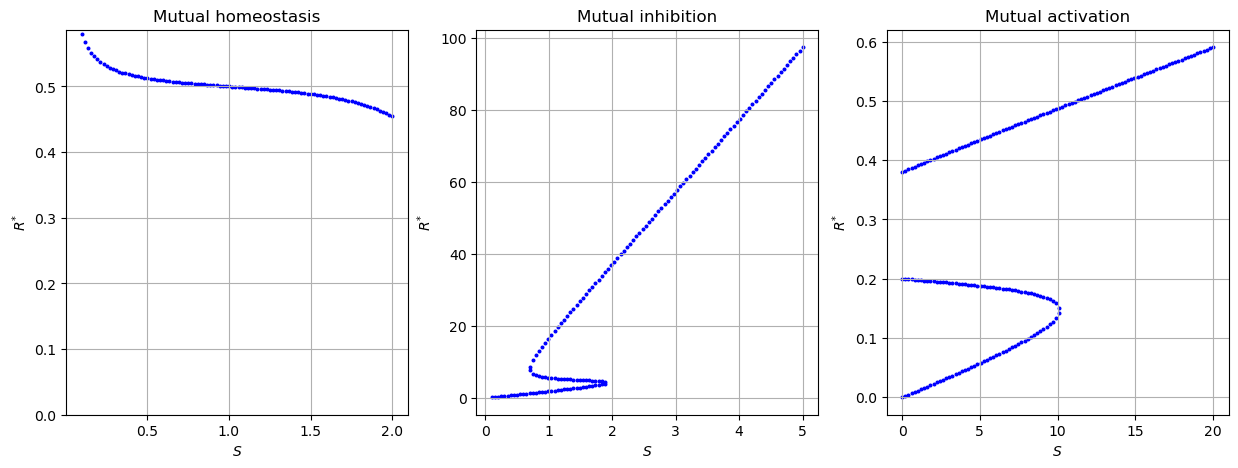

In [16]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

# Homeostasis
Ss = np.linspace(0.1, 2, 100)
xmin, xmax = 0, 10
dx = 0.1

bifurcation_plot(axs[0], root_function_homeostasis, Ss, xmin, xmax, dx)
axs[0].set_title("Mutual homeostasis")
axs[0].set_ylim(0,)

# Mutual inhibition
Ss = np.linspace(0.1, 5, 100)
xmin, xmax = 0, 100
dx = 1.0

bifurcation_plot(axs[1], root_function_mutual_inhibition, Ss, xmin, xmax, dx)
axs[1].set_title("Mutual inhibition")

# Mutual activation
Ss = np.linspace(0, 20, 100)
xmin, xmax = 0, 10
dx = 0.1

bifurcation_plot(axs[2], root_function_mutual_activation, Ss, xmin, xmax, dx)
axs[2].set_title("Mutual activation")

plt.show()

### c)


**b.** is mutual inhibition:
* "...signal $S$ enhances the synthesis of the response...": there is a dotted arrow from $S$ to reaction $\dots \rightarrow R$
* "...which in turn inhibits $E$ by phosphorylation...": there is a dotted arrow from $R$ to reaction $E \rightarrow EP$
* "...in this case, $E$ degrades $R$...": there is a dotted arrow from $E$ to reaction $R \rightarrow \dots$

**a.** must be mutual activation:

* "...signal $S$ enhances the synthesis of the response...": there is a dotted arrow from $S$ to reaction $\dots \rightarrow R$
* "...which in turn enhances its own synthesis via phosphorylating $E$...":
  * there is a dotted arrow from $R$ to reaction $E \rightarrow EP$ AND
  * there is a dotted arrow from $EP$ to reaction $\dots \rightarrow R$, meaning that phosphorylated $E$ (or simply $EP$) enhances the synthesis of $R$

**c.** must be negative feedback:
* "...the response $R$ counteracts the effect of the stimulus $S$...":
  * the dotted arrow from $S$ to reaction $R \rightarrow \dots$ means that $S$ degrades $R$
  * the dotted arrows from $R$ to reaction $EP \rightarrow E$ and from $E$ to reaction $\dots \rightarrow R$ mean that $R$ enhances the **dephosphorylation** of $EP$ and the resulting $E$ in turn enhances the synthesis of $R$
  
In summary, the above plots correspond to, in sequence, networks c., b. and a.

**a.** Mutual activation

**b.** Mutual inhibition

**c.** Negative feedback (homeostasis)

### d)

In negative feedback, the signal molecules bind to response molecules and catalyze their degradation. Free response molecules bind to $EP$ complexes allowing for dephosphorylation and resulting in activated free enzyme molecules $E$. Activated free enzymes then catalyze the synthesis of response molecules. In an excessive abundance of response molecules, the stimulus acts as a means to slow down the enzyme catalysis, reducing quantity of $R$ and pushing the system back to equilibrium.

In mutual inhibition, the signal molecules bind with a substrate, catalyzing the synthesis of response molecules. Free response molecules this time participate in phosphorylation of free enzyme molecules, deactivating them. Free enzyme molecules bind to response molecules, catalyzing their degradation. The synthesis of response molecules is self-enhacing in the sense that $R$ represses the process that causes its own depletion, hence the name "mutual inhibition".

In mutual activation, the signal molecules again bind with a subtrate, catalyzing the synthesis of response molecules. Free response molecules participate in phospohorylation of free enzyme molecules, this time activating them. The behaviour of enzyme if "flipped" as compared to mutual inhibition, in the sense that it is active when the phosphate group is bound to it and it enhances the synthesis of response, instead of degrading it. The synthesis of response molecules is self-enhacing in the sense that $R$ activates the process that causes its own augmentation, hence the name "mutual activation".

### e)

The role of a negative feedback mechanism in the system is to put it back into equilibrium. Abundance of $R$ is counteracted upon through slowing down the enzyme catalysis and enhacing the degradation. A reverse process occurs in case of scarcity of $R$. The system is always regulated to its stable point, which is why $R$ is confined to a narrow range of values.

## Part 3: LAC-operon

### a)

$k_1$ is the base transcription rate, a "default" mRNA synthesis constant.

$k_2(1 - \frac{1}{1 + A^{n}}) = k_2\frac{A^n}{1 + A^{n}}$ is the term describing production of mRNA induced by the presence of allolactose. We see that the "fraction" part of this formula is a Hill equation, reflecting that a saturation will be achieved for certain allolactose levels.

$k_3 M$ is the base mRNA decay term.

$k_4 ML$ is a term related to enzyme **permease** and its role in cellular import of lactose. $L$ is the lactose available in the medium. $M$ is the mRNA, therefore $M$ enhances the factor that also enhances $M$ itself. **This is a positive feedback mechanism.**

$k_5 A$ is the base allolactose decay term.

$V_{max} \frac{MA}{K_m + A}$ is the term related to $\beta$**-galactosidase** and its role in enzymatic degradation of allolactose. **It is a negative feedback** mechanism regulating the lactose conversion into allolactose and preventing the system from spiraling out of control due to the positive feedback term.



### b) Streamplots

Analytical solutions to nullclines $\frac{dM}{dt} = 0$ (1) and $\frac{dA}{dt} = 0$ (2):

1. $$\frac{dM}{dt} = 0 \iff M = \frac{k_1 + k_2 (1 - \frac{1}{1 + A^n})}{k_3}$$

2. $$\frac{dA}{dt} = 0 \iff M(k_4 L - V_{\max}\frac{A}{K_m + A}) = k_5 A \iff M = \frac{k_5 A}{(k_4 L - V_{\max}\frac{A}{K_m + A})}$$

In [17]:
def lac_operon(y0, k1, k2, k3, k4, k5, Vmax, Km, n, L):
    # System of two ODEs describing the relatshionship between allolaactose (A) and mRNA (M) in the LAC-operon
    M, A = y0

    dMdt = k1 + k2*(1 - 1 / (1 + A**n)) - k3*M
    dAdt = k4*M*L - k5*A - Vmax*M*A/(Km + A)

    return [dMdt, dAdt]

In [18]:
params_lac_operon_default = param_set(k1=0.05, k2=1, k3=1, k4=1, k5=0.2, Vmax=1, Km=2, n=5)
nd = 100
Ms = np.linspace(0., 2., nd)
As = np.linspace(0., 20., nd)

In [19]:
def get_dMdt_nullclines(As, k1, k2, k3, n, **kwargs):
    return (k1 + k2*(As**n / (1 + As**n))) / k3

def get_dAdt_nullclines(As, L, k4, k5, Vmax, Km, **kwargs):
    return (k5 * As) / (k4 * L - Vmax * (As / (Km + As)))

def equilibrium_point(As, L, k1, k2, k3, k4, k5, Vmax, Km, n):
    return (k1 + k2*(As**n / (1 + As**n))) / k3 - (k5 * As) / (k4 * L - Vmax * (As / (Km + As)))

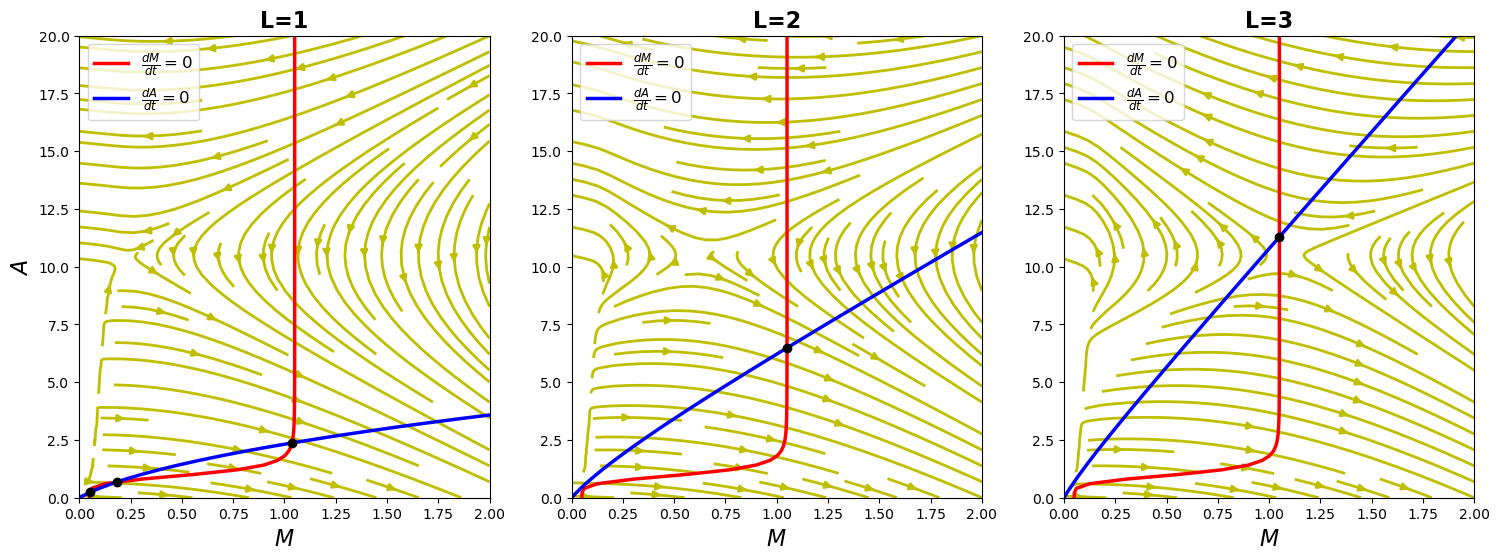

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

ax[0].set_ylabel(r"$A$", size=16)

for L in range(1,4):
    dMdts = np.zeros((nd, nd))
    dAdts = np.zeros((nd, nd))

    for (i, M) in enumerate(Ms):
        for (j, A) in enumerate(As):
            dMdts[i, j], dAdts[i, j] = lac_operon((M, A), L=L, *params_lac_operon_default.values())

    ax[L-1].streamplot(Ms, As, dMdts, dAdts, color='y', linewidth=2)
    ax[L-1].plot(get_dMdt_nullclines(As, **params_lac_operon_default), As, color="red", lw=2.5, label=r"$\frac{dM}{dt} = 0$")
    ax[L-1].plot(get_dAdt_nullclines(As, L, **params_lac_operon_default), As, color="blue", lw=2.5, label=r"$\frac{dA}{dt} = 0$")
    ax[L-1].legend(loc="upper left", fontsize=12)
    ax[L-1].set_xlim(0,2)
    ax[L-1].set_xlabel(r"$M$", size=16)
    ax[L-1].set_title(f"L={L}", fontweight="bold", size=16)

    # Find equilibrium points and plot them
    root_func = lambda A : equilibrium_point(A, L=L, **params_lac_operon_default)
    roots = find_roots(root_func, 0.0, 20.0, 0.5)

    for A_root in roots:
        ax[L-1].scatter(get_dMdt_nullclines(A_root, **params_lac_operon_default), A_root, color="k", zorder=10)

plt.show()

### c) Equilibrium points and the Jacobian matrix

Derivation of the Jacobian matrix:

$$
\begin{align*}
    \mathbf{J} = \begin{bmatrix} \frac{d(dM/dt)}{dM} & \frac{d(dM/dt)}{dA} \\ \\ \frac{d(dA/dt)}{dM} & \frac{d(dA/dt)}{dA} \end{bmatrix} \\
\end{align*}
$$

---

$$
\begin{align*}
\frac{d(dM/dt)}{dM} = -k_3
\end{align*}
$$

---

$$
\begin{align*}
\frac{d(dM/dt)}{dA} &= k_2 - k_2 \frac{d}{dA} \left[ \frac{1}{1 + A^5} \right] = \\
    &= k_2 + k_2 \frac{5A^4}{(1 + A^5)^2}
\end{align*}
$$

---

$$
\begin{align*}
\frac{d(dA/dt)}{dM} = k_4 L - V_{max} \frac{A}{K_M + A} \\
\end{align*}
$$

---

$$
\begin{align*}
\frac{d(dA/dt)}{dA} &= -k_5 - \frac{d}{dA} \left[ MA \cdot V_{max}(K_m + A)^{-1} \right] = \\
    &= -k_5 - MV_{max} \frac{d}{dA} \left[ A (K_m + A)^{-1} \right] = \\
    &= -k_5 - MV_{max} \frac{1 \cdot (K_m + A) - 1 \cdot A}{(K_m + A)^2} = \\
    &= -k_5 - MV_{max} \frac{K_m}{(K_m + A)^2} = \\
\end{align*}
$$

---

$$
\begin{align*}
    \mathbf{J} &= \begin{bmatrix} -k_3 & k_2 + k_2 \frac{5A^4}{(1 + A^5)^2} \\ \\ k_4 L - V_{max} \frac{A}{K_M + A} & -k_5 - MV_{max} \frac{K_m}{(K_m + A)^2} \end{bmatrix} = \\
    &= \begin{bmatrix} -1 & 1 + 1 \frac{5A^4}{(1 + A^5)^2} \\ \\ L - \frac{A}{2 + A} & - 0.2 - M \frac{2}{(2 + A)^2} \end{bmatrix} = \\
\end{align*}
$$

In [21]:
def jacobian(M, A, L):
    ddMdtdM = -1
    ddMdtdA = 1 + 1 * (5*A**4) / (1 + A**5)**2
    ddAdtdM = L - (A / (2 + A))
    ddMdtdA = -0.2 - M * 2 / (2 + A)**2
    return np.array([[ddMdtdM, ddMdtdA],[ddAdtdM, ddMdtdA]])

def plot_equilibrium_points(ax, Ms, As, A_root, dMdts, dAdts, L):
    M_root = get_dMdt_nullclines(A_root, **params_lac_operon_default)

    ax.scatter(M_root, A_root, color="k", zorder=10, s=100)
    ax.streamplot(Ms, As, dMdts, dAdts, color='y', linewidth=2)
    ax.plot(get_dMdt_nullclines(As, **params_lac_operon_default), As, color="red", lw=2.5, label=r"$\frac{dM}{dt} = 0$")
    ax.plot(get_dAdt_nullclines(As, L, **params_lac_operon_default), As, color="blue", lw=2.5, label=r"$\frac{dA}{dt} = 0$")
    ax.legend(loc="upper left", fontsize=12)
    ax.set_xlim(0,2)
    ax.set_xlabel(r"$M$", size=16)

    # Create Jacobian and obtain the eigenvalues
    J = jacobian(M_root, A_root, L)

    eigenvalues, _ = np.linalg.eig(J)
    l1, l2 = np.round(eigenvalues, 2)

    ax.set_title(r"$\{\lambda_1, \lambda_2 \} = \{$" + f"{l1}, " + f"{l2}" + r"$\}$", size=12)

##### L = 1

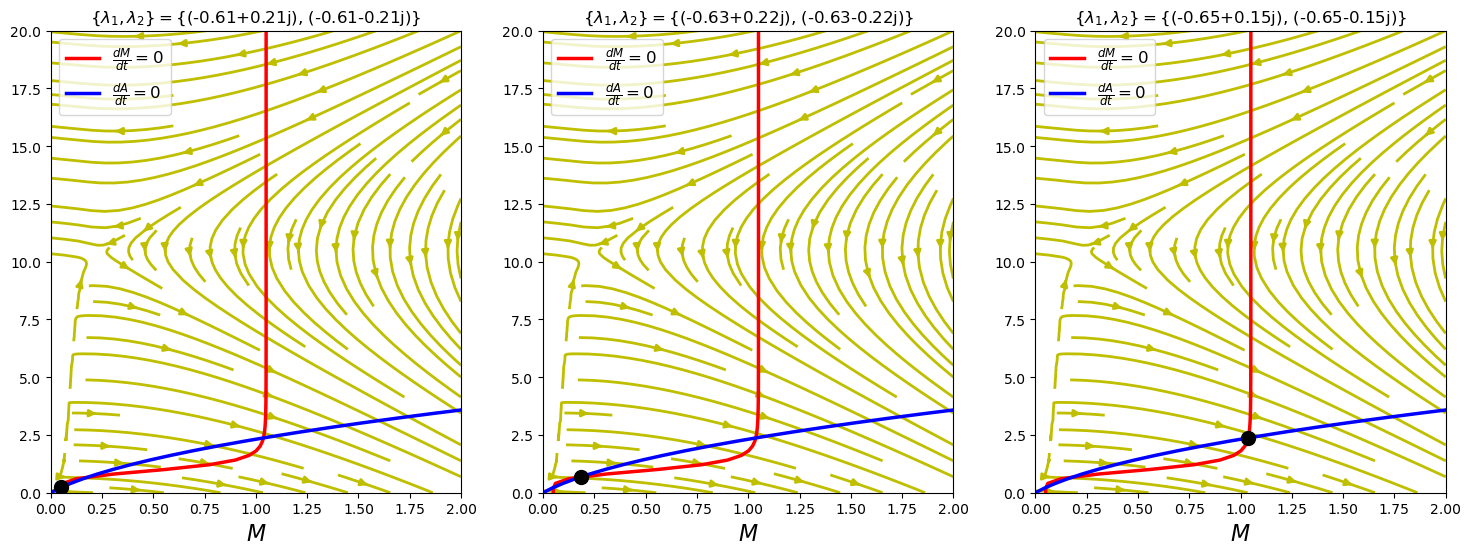

In [22]:
dMdts = np.zeros((nd, nd))
dAdts = np.zeros((nd, nd))
L = 1

for (i, M) in enumerate(Ms):
        for (j, A) in enumerate(As):
            dMdts[i, j], dAdts[i, j] = lac_operon((M, A), L=L, **params_lac_operon_default)

root_func = lambda A : equilibrium_point(A, L=L, **params_lac_operon_default)
roots = find_roots(root_func, 0.0, 20.0, 0.5)

fig, ax = plt.subplots(1, roots.shape[0], figsize=(roots.shape[0] * 6, 6))
for (i, A_root) in enumerate(roots):
    plot_equilibrium_points(ax[i], Ms, As, A_root, dMdts, dAdts, L)
plt.show()

All of the three equilirium points are complex conjugates with negative real parts, therefore all of them are **stable spirals**.

##### L = 2

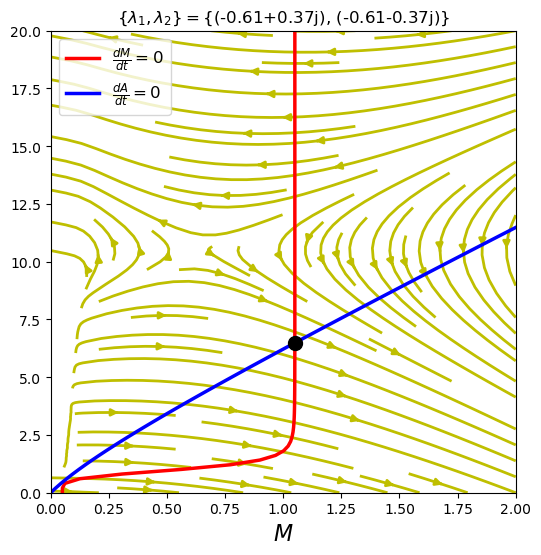

In [23]:
dMdts = np.zeros((nd, nd))
dAdts = np.zeros((nd, nd))
L = 2

for (i, M) in enumerate(Ms):
        for (j, A) in enumerate(As):
            dMdts[i, j], dAdts[i, j] = lac_operon((M, A), L=L, **params_lac_operon_default)

root_func = lambda A : equilibrium_point(A, L=L, **params_lac_operon_default)
A_root = find_roots(root_func, 0.0, 20.0, 0.5)[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_equilibrium_points(ax, Ms, As, A_root, dMdts, dAdts, L)
plt.show()

The equilibrium point is a complex conjugate with negative real part. It is a **stable spiral**.

##### L = 3

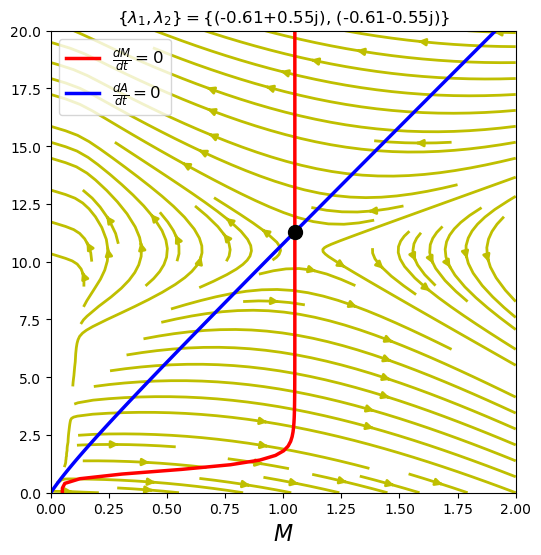

In [24]:
dMdts = np.zeros((nd, nd))
dAdts = np.zeros((nd, nd))
L = 3

for (i, M) in enumerate(Ms):
        for (j, A) in enumerate(As):
            dMdts[i, j], dAdts[i, j] = lac_operon((M, A), L=L, **params_lac_operon_default)

root_func = lambda A : equilibrium_point(A, L=L, **params_lac_operon_default)
A_root = find_roots(root_func, 0.0, 20.0, 0.5)[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_equilibrium_points(ax, Ms, As, A_root, dMdts, dAdts, L)
plt.show()

The equilibrium point is a complex conjugate with negative real part. It is a **stable spiral**.

The equilibrium points in all cases represent a **dynamic equibilrium**. Time derivatives of chemical concentrations are all equal to zero, meaning that concentrations achieved a stable state and don't change anymore. This, however, is not because there is no chemical activity in the system, but rather because the sum of producing reactions equal to the sum of consuming reactions.

### d) & e) Time-dependent dynamics

In [25]:
def lac_operon(y0, t, k1, k2, k3, k4, k5, Vmax, Km, n, L):
    # System of two ODEs describing the relatshionship between allolaactose (A) and mRNA (M) in the LAC-operon
    M, A = y0

    dMdt = k1 + k2*(1 - 1 / (1 + A**n)) - k3*M
    dAdt = k4*M*L - k5*A - Vmax*M*A/(Km + A)

    return [dMdt, dAdt]

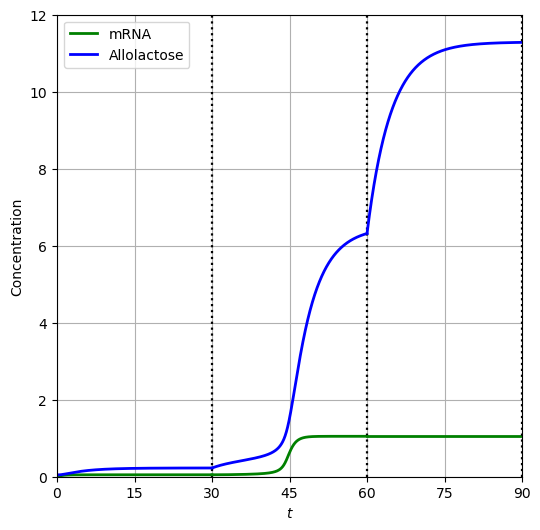

In [26]:
y0 = [0.0, 0.05]

k1, k2, k3, k4, k5, Vmax, Km, n = params_lac_operon_default.values()

Ls = np.array([1,2,3])
fig, ax = plt.subplots(1,1,figsize=(6,6))

for (i, L) in enumerate(Ls):
    t = np.linspace(i*30, (i+1)*30, 1000)
    sol = odeint(lac_operon, y0, t, args=(k1, k2, k3, k4, k5, Vmax, Km, n, L))

    M, A = sol[:, 0], sol[:, 1]
    ax.plot(t, M, color="green", lw=2.0)
    ax.plot(t, A, color="blue", lw=2.0)

    ax.vlines((i+1)*30, 0, 15, linestyles="dotted", lw=1.6, color="black")

    y0 = [M[-1], A[-1]]

ax.set_xlim(0,90)
ax.set_ylim(0,12)
ax.set_xticks([0,15,30,45,60,75,90])
ax.set_xlabel(r"$t$")
ax.set_ylabel("Concentration")
ax.legend(["mRNA", "Allolactose"])
ax.grid()

plt.show()


Looking at the plot, clearly, the dynamics of this system are quite complex. The behaviour of neither the allolactose nor mRNA is exactly the same in any of three intervals.

At first $(L = 1)$, we observe a small amount of lactose molecules being introduced to the medium. These lactose molecules are imported to the system and converted into allolactose (A) molecules. Allolactose molecules bind to the repressor protein and deactivate it, allowing RNA polymerase to bind to the DNA sequence and begin the transcription of DNA to mRNA. Allolactose concentration quickly achieves a stable state and ignites the initial production of mRNA, reflected in the plot by its increase in concentration to barely above zero.

By introducing more lactose into the system $(L = 2)$, the allolactose molecules become abundant enough to further shut down the repressor protein. The transcript of mRNA being produced contains information that sparks the production of permease enzyme, which further helps to import more lactose into the system. The positive feedback mechanism becomes to kick in with R and A rates mutually enhancing each other. This is reflected in the plot by a slower concentration increase at $t \in [ 30, 45 ]$, which becomes faster as the time progresses. A maximal rate is achieved at around $t = 45$, with rates slowing down after that threhsold.

At this point, the system becomes saturated and the negative feedback becomes more prevalent. Almost all repressor molecules are inactivated through the abundatn allolactose. The 'A' molecules being further introduced to the system remain free, with no inhibitors to bind to. The RNA is synthesized at its maximum rate. Through, again, the information stored in mRNA transcript, the $\beta$-galactosidase enzymes are produced. These enzyme molecules bind to free allelactose molecules and degrade them. This whole process is reflected in the plot by mRNA achieving its equilibrium concentration at around $t = 50$ and a slowed down increase in allolactose concentration from $t = 45$ onwards.

When even more lactose is introduced $(L = 3)$, the system is fully saturated. All repressor proteins are deactivated and the transcription processed is finished. No more RNA is synthesized and no positive feedback mechanism occurs. The allolactose is slowly degraded untill it again reaches a stable state.

The system is a bit similar to the perfect adaptation network from Question 1. There, $X$ concentration also increased in "bumps" at each interval and $R$ increased at first when the control parameter $S$ was set to $1$, but then achieved a stable equilibrium value and the negative feedback kept downregulating it to this equilibrium indepdently of increase in control parameter. Here, the "bumps" have a more complex nature, due to the introduction of positive feedback and the response (mRNA) does not need downregulating, as it never leaves the equilibrium when $L$ is set to $3$.

## Question 4: Ionic Channels

### a) Does it go to equillibrium ?

By setting all time derivatives to zero, we can observe that this system has infinitely many equilibrium points in the form $\{ x_0, y_0, z_0 \} = \{ 0, 0, z \}$ with $z \in \mathbb{R}$. The nature of these equilibrium points is independent from $x, y, z$. This becomes clear when we construct the Jacobian matrix:

$$ \mathbf{J} = \begin{bmatrix} -k_1 & k_2 & 0 \\ k_1 & -(k_2 + k_3) & 0 \\ 0 & k_3 & 0 \\ \end{bmatrix} $$

The characteristic polynomial of this matrix is given by:

$$
\begin{align*}
    \text{det}(\lambda \mathbf{I} - \mathbf{J}) = 0 & \iff -\lambda^3 - k_1 \lambda^2 - k_2 \lambda^2 - k_3 \lambda - k_1 k_3 \lambda =  0 \\
    & = -\lambda \left( \lambda^2 + (k_1 + k_2 + k_3) \lambda + k_1 k_3 \lambda \right) = 0\\
\end{align*}
$$

The trivial solution to this equation is $\lambda = 0$. This corresponds to the infinite amount of equilibriums along the $z$-axis. The remaining two eigenvalues can be determined by solving the quadratic formula. The $\Delta$ is given by:

$$ 
\begin{align*}
\Delta &= (k_1 + k_2 + k_3)^2 - 4 k_1 k_3 = \\
    &= k_1^2 + k_2^2 + k_3^2 + 2 k_1 k_2 + 2 k_1 k_3 + 2 k_2 k_3 - 4 k_1 k_3 = \\
    &= (k_1 - k_3)^2 + k^2 + 2 k_1 k_2 + 2 k_2 k_3,
\end{align*}
$$

which is a positive value given that $k_1, k_2, k_3 \gt 0$. There are two distinct solutions (eigenvalues) to this equation and they are real eigenvalues.

Now we use Viet's formulas for quadratic polynomials.

$$ 
\begin{align*}
    \lambda_1 + \lambda_2 &= k_1 + k_2 + k_3 \\
    \lambda_1 \cdot \lambda_2 &= k_1 k_3 \\
\end{align*}
$$

Given that $k_1, k_2, k_3 \gt 0$ this yields two real positive eigenvalues $\lambda_1, \lambda_2$. The equilibrium point $\{ 0, 0, z \}$ is an unstable node (repeller) along the $x,y$ plane. The system does not go to equilibrium.


### b) Streamplot

The nullclines for $\frac{dx}{dt} = 0$ and $\frac{dy}{dt} = 0$ are given by:

$$
\begin{align*}
    y(x) \mid_{\frac{dx}{dt} = 0} &= \frac{k_1}{k_2} x \\
    y(x) \mid_{\frac{dy}{dt} = 0} &= \frac{k_1}{k_2 + k_3} x \\
\end{align*}
$$

In [54]:
def ionic_channels(y0, t=-1, k=[-1,-1,-1]):
    """ODE system for ionic channels. The t parameter allows to reuse the method for time-dependent simulations."""
    x, y, z = y0
    k1, k2, k3 = k

    dxdt = k2*y - k1*x
    dydt = k1*x - (k2 + k3)*y
    dzdt = k3*y

    return [dxdt, dydt, dzdt]

In [55]:
def dxdt_nullcline(x, k):
    k1, k2, _ = k
    return (k1 / k2) * x

def dydt_nullcline(x, k):
    k1, k2, k3 = k
    return (k1 / (k2 + k3)) * x

In [56]:
nd = 500
xs = np.linspace(0, 1, nd)
ys = np.linspace(0, 1, nd)

k = [2,2,1]

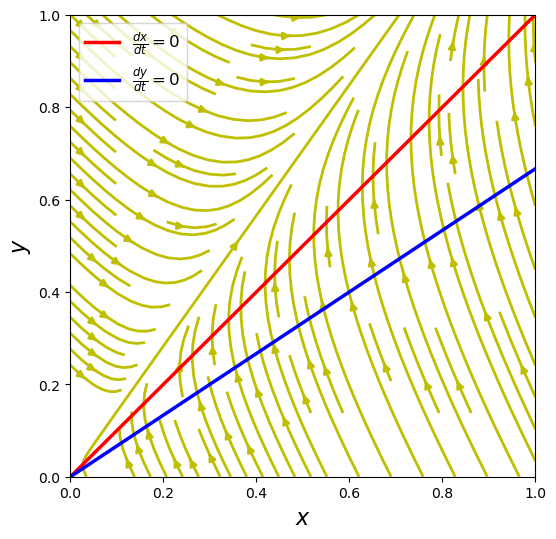

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

dxdts = np.zeros((nd, nd))
dydts = np.zeros((nd, nd))

for (i, x) in enumerate(xs):
    for (j, y) in enumerate(ys):
        dxdts[i, j], dydts[i, j], _ = ionic_channels([x, y, -1], k)

ax.streamplot(xs, ys, dxdts, dydts, color='y', linewidth=2)

ax.plot(xs, dxdt_nullcline(xs, k), color="red", lw=2.5, label=r"$\frac{dx}{dt} = 0$")
ax.plot(xs, dydt_nullcline(xs, k), color="blue", lw=2.5, label=r"$\frac{dy}{dt} = 0$")

ax.legend(loc="upper left", fontsize=12)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.set_ylabel(r"$y$", size=16)
ax.set_xlabel(r"$x$", size=16)
plt.show()

The $x,y$ nullclines in this system are given by linear equations which cross at an equillibrium point $\{ 0, 0 \}$ as predicted in the analysis. The streamplot clearly indicates that the flow in this system is pointing away from the equilibrium, as all the arrows are facing away from $\{ 0, 0 \}$, into increasing $x, y$ values. This corresponds with our predictions made in (a). The system generally does not achieve equillibrium as the equillibrium point is a repeller.

### c) Time-dependent simulation

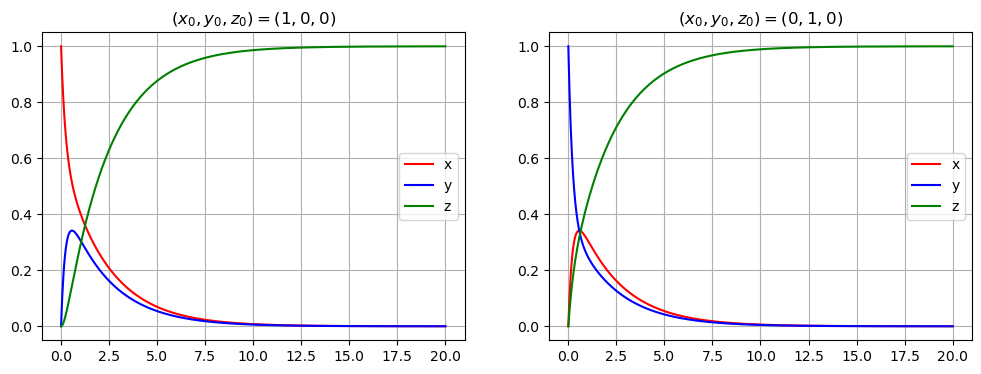

In [58]:
t = np.linspace(0, 20, 1000)

def plot_ionic_channels(ax, t, x, y, z, y0):
    ax.plot(t, x, color="red", label="x")
    ax.plot(t, y, color="blue", label="y")
    ax.plot(t, z, color="green", label="z")
    ax.legend()
    ax.grid()
    ax.set_title(f"$(x_0, y_0, z_0) = {tuple(y0)}$")

fig, axs = plt.subplots(1,2,figsize=(12,4))
y0 = [1, 0, 0]
sol = odeint(ionic_channels, y0, t, args=(k,))
x, y, z = sol[:, 0], sol[:, 1], sol[:, 2]
plot_ionic_channels(axs[0], t, x, y, z, y0)

y0 = [0, 1, 0]
sol = odeint(ionic_channels, y0, t, args=(k,))
x, y, z = sol[:, 0], sol[:, 1], sol[:, 2]
plot_ionic_channels(axs[1], t, x, y, z, y0)
plt.show()

The system did actually achieve a stable point, contradicting our predictions from (a) and (b).

### d)

On a molecular level, this means that no longer the channels in state $S_1$ can transition into state $S_2$. This means that the fraction of open channels ($S_2$) can only decline.

### e)

The rewritten system of ODEs is now:

$$
\begin{align*}
    \frac{dx}{dt} &= k_2y \\
    \frac{dy}{dt} &= -(k_2 + k_3)y \\
    \frac{dz}{dt} &= k_3y \\
\end{align*}
$$

In this version of the system, ionic channels undergo a one-way transform from and open state to a closed state. $S_2$ channels transform to $S_1$ with rate $k_2$ and to $S_3$ with rate $k_3$. The system clearly should go to equilibrium where there no more open channels and the final proportions of $S_1$ and $S_3$, as compared to the initial state, are distributed according to $k_2$ and $k_3$.

### f)

In [59]:
def ionic_channels2(y0, t=-1, k=[-1,-1,-1]):
    """ODE system for ionic channels. The t parameter allows to reuse the method for time-dependent simulations."""
    x, y, z = y0
    k2, k3 = k

    dxdt = k2*y
    dydt = -(k2 + k3)*y
    dzdt = k3*y

    return [dxdt, dydt, dzdt]

In [60]:
k = [2,1]

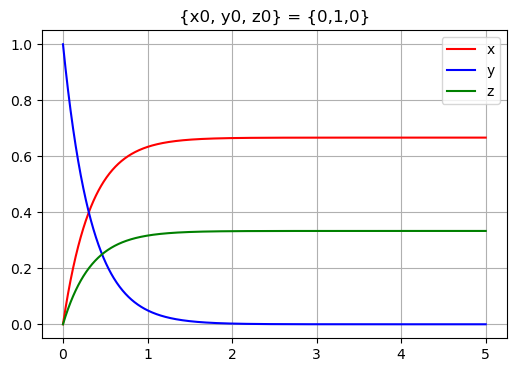

In [62]:
t = np.linspace(0, 5, 1000)

fig, ax = plt.subplots(1,1,figsize=(6,4))

y0 = [0, 1, 0]
sol = odeint(ionic_channels2, y0, t, args=(k,))
x, y, z = sol[:, 0], sol[:, 1], sol[:, 2]

ax.plot(t, x, color="red", label="x")
ax.plot(t, y, color="blue", label="y")
ax.plot(t, z, color="green", label="z")
ax.legend()
ax.grid()
ax.set_title("{x0, y0, z0} = {0,1,0}")

plt.show()

Yes, the conclusions correspond with predictions from (e). Once all open channels were depleted, the system achieved equillibrium. Since $k_2 = 2 k_3$, the final proportion of $S_1$ ($x$ variable) was twice the proportion of $S_3$ ($z$ variable).

### g)

The system achieves equillibrium at a certain point in time, meaning that the values of $x, y, z$ don't change anymore. This values can be set as $x^{*}, y^{*}, z^{*}$. Then in the limit of infinite amount of time, the system at some points achieves this equillibrium.

### h)

$$ y^{*} = \lim_{t \rightarrow +\infin} y(t) = \lim_{t \rightarrow +\infin} \frac{1}{e^{3t}} = 0 $$

### i)

$$
\begin{align*}
    \frac{dx}{dt} &= k_2y \\
    dx &= k_2 y(t) dt \\
    \int_{x(0) = 0}^{x^{*}} dx &= k_3 \int_{0}^{\infin} y(t) dt \\
    [x]_{0}^{x^{*}} &= - \frac{k_2}{k_2 + k_3} [ y(t) ]_{0}^{\infin} \\
    x^{*} &= - \frac{k_2}{k_2 + k_3} (0 - 1) \\
    x^{*} &= \frac{k_2}{k_2 + k_3} \\
\end{align*}
$$

---

$$
\begin{align*}
    \frac{dz}{dt} &= k_3y \\
    dz &= k_3 y(t) dt \\
    \int_{z(0) = 0}^{z^{*}} dz &= k_3 \int_{0}^{\infin} y(t) dt \\
    [z]_{0}^{z^{*}} &= - \frac{k_3}{k_2 + k_3} [ y(t) ]_{0}^{\infin} \\
    z^{*} &= - \frac{k_3}{k_2 + k_3} (0 - 1) \\
    z^{*} &= \frac{k_3}{k_2 + k_3} \\
\end{align*}
$$

### j)

Yes, as already noted in (f), the final proportion of $S_1$ ($x$ variable) was twice the proportion of $S_3$ ($z$ variable). Substituting $k_2 = 2$, $k_3 = 1$ we get:

$$ x^{*} = \frac{2}{3} $$

$$ z^{*} = \frac{1}{3} $$

which corresponds with our equillibrium points from (f).